In [79]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/Marketing_Prediction")

data = pd.read_csv("data.csv", na_values=["", "NA"])

In [80]:
import pandas as pd
import numpy as np

# Replace missing or empty values in columns 4, 5, 6 with "unknown"
data.iloc[:, [3, 4, 5]] = data.iloc[:, [3, 4, 5]].applymap(lambda x: "unknown" if pd.isna(x) or x == "" else x)

# Replace income with appropriate midpoints or custom values
income_mapping = {
    "unknown": 6,              # replacing unknown with the median income level
    "Under $10k": 1,            # midpoint of "Under $10k"
    "10-19,999": 2,            # midpoint of "10-19,999"
    "20-29,999": 3,            # midpoint of "20-29,999"
    "30-39,999": 4,            # midpoint of "30-39,999"
    "40-49,999": 5,            # midpoint of "40-49,999"
    "50-59,999": 6,            # midpoint of "50-59,999"
    "60-69,999": 7,            # midpoint of "60-69,999"
    "70-79,999": 8,            # midpoint of "70-79,999"
    "80-89,999": 9,            # midpoint of "80-89,999"
    "90-99,999": 10,            # midpoint of "90-99,999"
    "100-149,999": 11,         # midpoint of "100-149,999"
    "150 - 174,999": 12,       # midpoint of "150 - 174,999"
    "175 - 199,999": 13,       # midpoint of "175 - 199,999"
    "200 - 249,999": 14,       # midpoint of "200 - 249,999"
    "250k+": 15               # custom value for "250k+"
}
data["income"] = data["income"].map(income_mapping).astype(int)

# Replace gender with 1 for male, 0 for female, and 0 for unknown
gender_mapping = {"M": 1, "F": 0, "unknown": 0}
data["gender"] = data["gender"].map(gender_mapping).astype(int)

# Replace marital_status with 1 for married, 0 for single, and 1 for unknown
marital_status_mapping = {"M": 1, "S": 0, "unknown": 1}
data["marital_status"] = data["marital_status"].map(marital_status_mapping).astype(int)

# Convert target to categorical values (0 or 1)
data["target"] = data["target"].astype(int)

# Convert distance (dist) column to integer
data["dist"] = data["dist"].astype(int)

/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_6910/2211222545.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data.iloc[:, [3, 4, 5]] = data.iloc[:, [3, 4, 5]].applymap(lambda x: "unknown" if pd.isna(x) or x == "" else x)


In [81]:
display(data.head())

,id,age,dist,income,gender,marital_status,target
0,1,73,4,10,1,0,1
1,2,89,1,11,1,1,1
2,3,85,1,2,0,0,1
3,4,76,2,10,1,1,1
4,5,76,2,2,1,0,1


We want to build a Binary Classifier model. Let's build a Logistic Regression and do some preliminary diagnostic to see if such a model would be appropiate for our give data. 

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictor = data[['age', 'dist', 'income','gender','marital_status']] 
response = data['target']  

model = LogisticRegression()
model.fit(predictor, response) 

LogisticRegression()

Check our model summary 

distance is insignifigant 

In [83]:
import statsmodels.api as sm

predictor = data[['age', 'income','dist', 'gender', 'marital_status']]
response = data['target']

predictor_with_const = sm.add_constant(predictor)

logit_model = sm.Logit(response, predictor_with_const)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.527865
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 4000
Model:                          Logit   Df Residuals:                     3994
Method:                           MLE   Df Model:                            5
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                 0.06130
Time:                        15:59:57   Log-Likelihood:                -2111.5
converged:                       True   LL-Null:                       -2249.3
Covariance Type:            nonrobust   LLR p-value:                 1.619e-57
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.3820      0.401    -10.915      0.000      -5.169      -3.595
age              

The Pseudo R-square isn't great, let's check out the Logit plots of our predictors as they all reject the null that they equal zero 

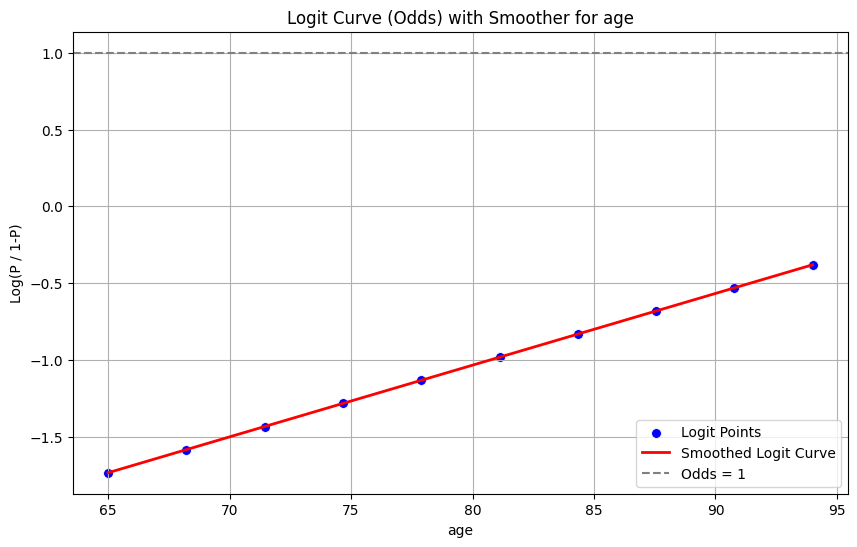

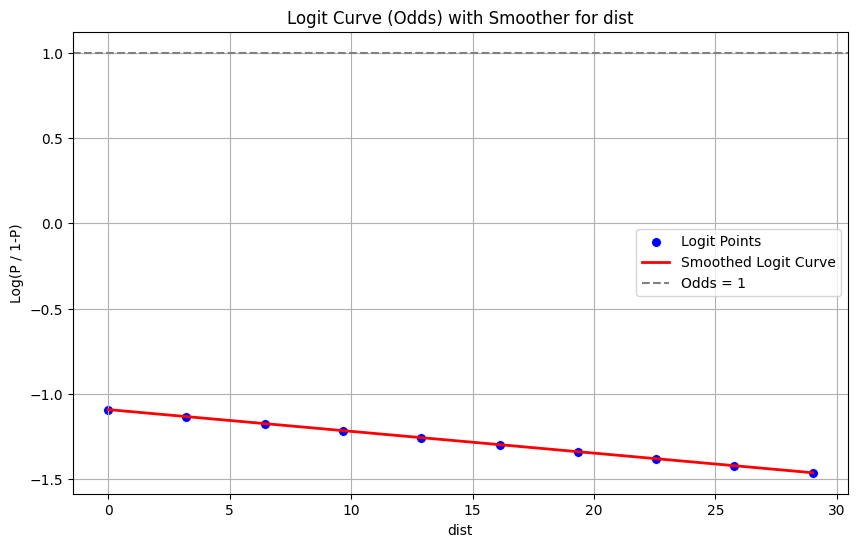

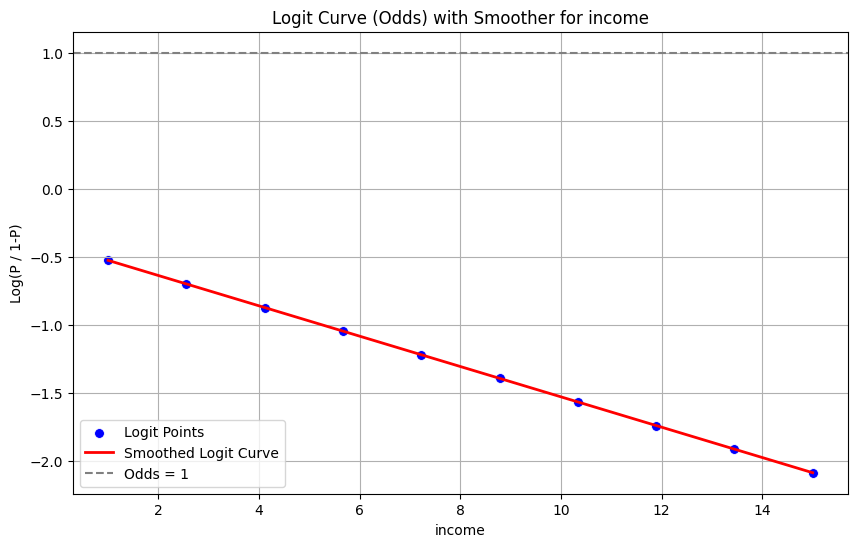

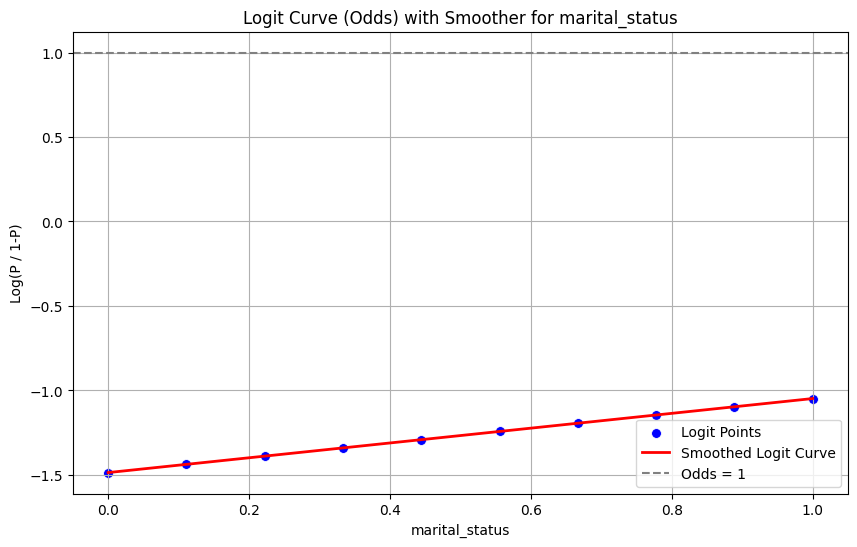

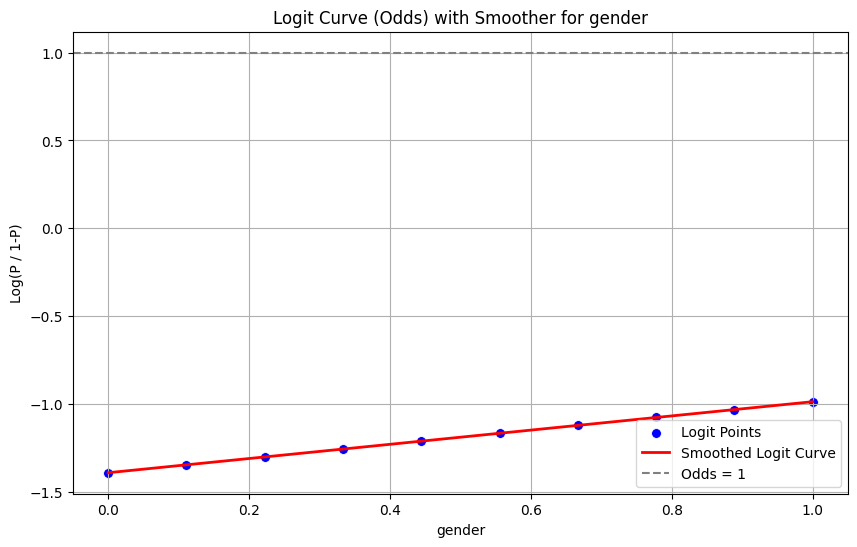

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def plot_logit_curve_with_smoother(result, predictor, feature_name):
    """
    Plot the logit curve (odds) for a given feature with scatter points and a smoother.

    Parameters:
    - result: Fitted logistic regression model.
    - predictor: Training dataset of predictors.
    - feature_name: The feature for which to plot the logit curve.
    """
    # Generate a range of values for the selected feature
    feature_values = np.linspace(predictor[feature_name].min(), predictor[feature_name].max(), 10)
    
    # Keep other predictors fixed at their mean
    fixed_predictors = predictor.mean(axis=0).copy()
    
    # Calculate the logit (odds) for each feature value
    log_odds = []
    for value in feature_values:
        temp_predictors = fixed_predictors.copy()
        temp_predictors[feature_name] = value
        
        # Add constant and ensure shape matches model coefficients
        predictors_with_const = sm.add_constant(temp_predictors.values.reshape(1, -1), has_constant='add')
        logit = np.dot(predictors_with_const, result.params)
        #odds = np.exp(logit)  this is ploting the log(p/1-p) i just ommited the exp()
        log_odds.append(logit[0])
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        feature_name: feature_values,
        'log_odds': log_odds
    })
    
    # Plot the logit curve with points and smoother
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature_name, y='log_odds', data=plot_df, color='blue', s=50, label='Logit Points')
    sns.regplot(x=feature_name, y='log_odds', data=plot_df, scatter=False, lowess=True, 
                color='red', line_kws={'lw': 2}, label='Smoothed Logit Curve')
    
    plt.title(f'Logit Curve (Odds) with Smoother for {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Log(P / 1-P)')
    plt.axhline(1, color='grey', linestyle='--', label='Odds = 1')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_logit_curve_with_smoother(result, predictor, 'age')
plot_logit_curve_with_smoother(result, predictor, 'dist')
plot_logit_curve_with_smoother(result, predictor, 'income')
plot_logit_curve_with_smoother(result, predictor, 'marital_status')
plot_logit_curve_with_smoother(result, predictor, 'gender')



These are incredibly weak predictors. Are these variables even coorelated with the outcome in the first place? 

In [85]:
import pandas as pd
from scipy.stats import pointbiserialr

def calculate_point_biserial(df, continuous_var, binary_var):
    """
    Calculate the point-biserial correlation between a continuous predictor and a binary variable.
    
    Parameters:
    - df: Pandas DataFrame containing the data.
    - continuous_var: Name of the continuous predictor column.
    - binary_var: Name of the binary dependent variable column.

    Returns:
    - correlation: Point-biserial correlation coefficient.
    - p_value: p-value for testing significance of the correlation.
    """
    # Ensure the binary variable only contains 0 and 1
    if not set(df[binary_var].unique()).issubset({0, 1}):
        raise ValueError("The binary variable must only contain 0 and 1.")
    
    # Calculate point-biserial correlation
    correlation, p_value = pointbiserialr(df[continuous_var], df[binary_var])
    
    print(f"Point-Biserial Correlation between {continuous_var} and {binary_var}: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")
    return correlation, p_value


calculate_point_biserial(data, 'age', 'target')
calculate_point_biserial(data, 'dist', 'target')
calculate_point_biserial(data, 'income', 'target')
calculate_point_biserial(data, 'marital_status', 'target')
calculate_point_biserial(data, 'gender', 'target')

Point-Biserial Correlation between age and target: 0.1970
P-value: 2.8301e-36
Point-Biserial Correlation between dist and target: -0.0293
P-value: 6.3509e-02
Point-Biserial Correlation between income and target: -0.1585
P-value: 6.3378e-24
Point-Biserial Correlation between marital_status and target: 0.0488
P-value: 2.0292e-03
Point-Biserial Correlation between gender and target: 0.0667
P-value: 2.4297e-05


(np.float64(0.06669003349761873), np.float64(2.429733607385458e-05))

the greatest coorelation here is age, let's see a scatter plot of the age and 
NO NO NO NO, THIS ISN'T PLOTTING THE DATA, THIS IS PLOTTING THE MODEL 

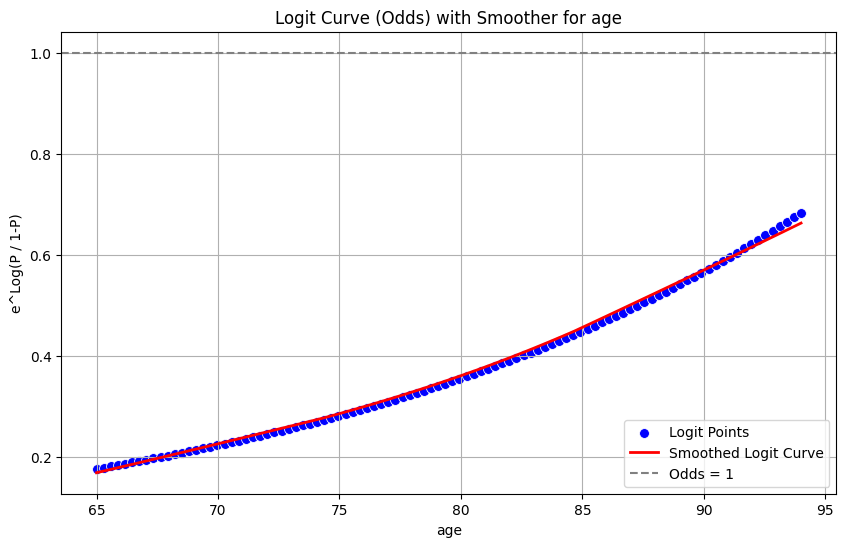

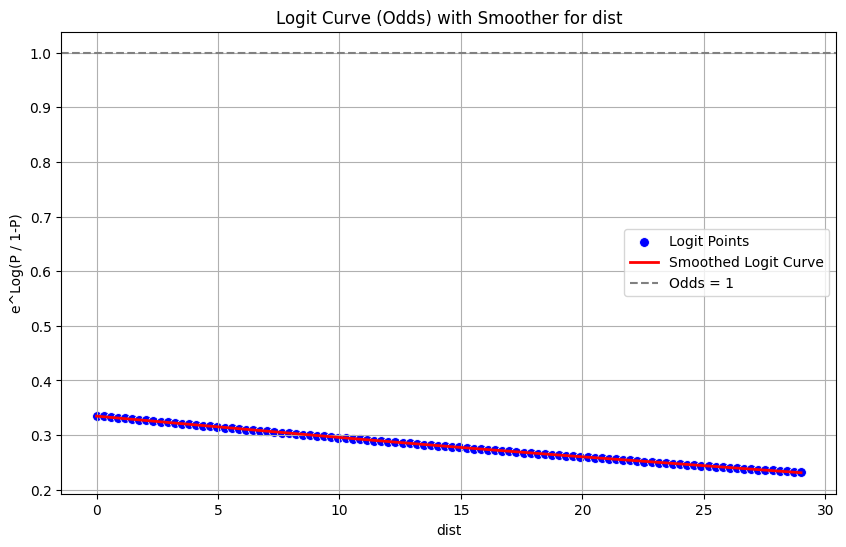

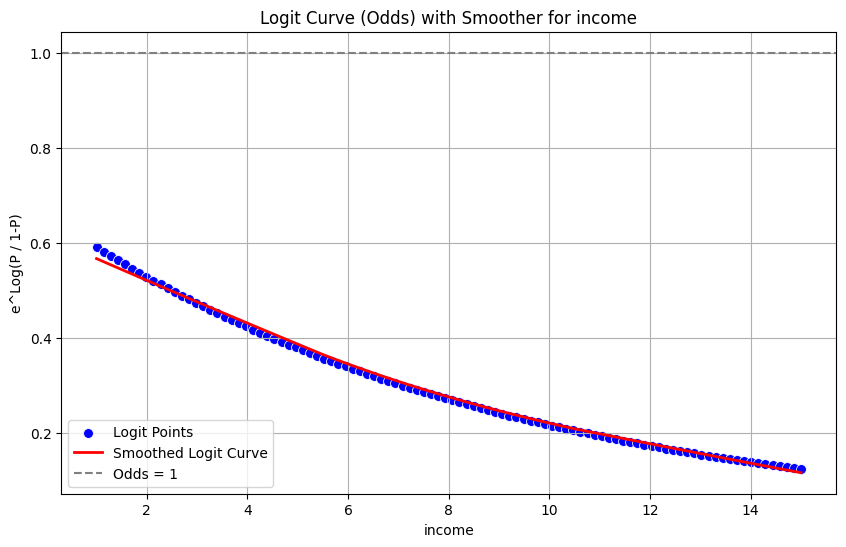

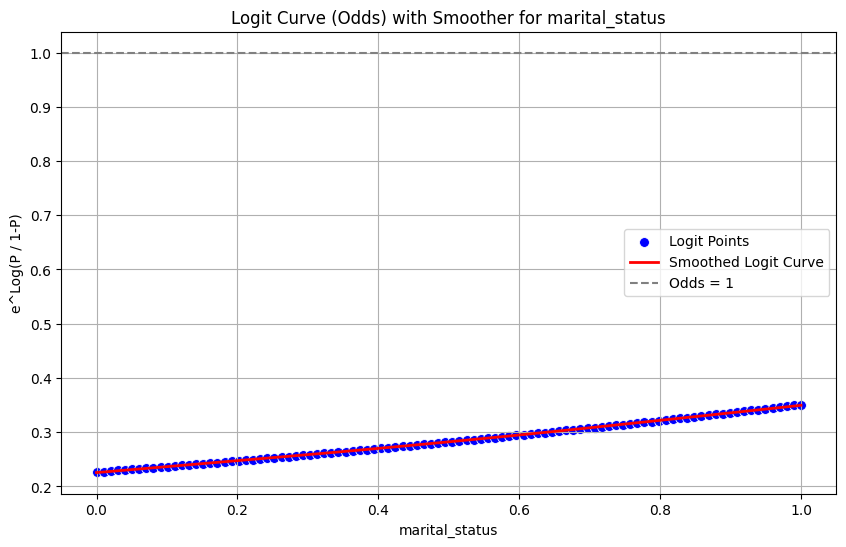

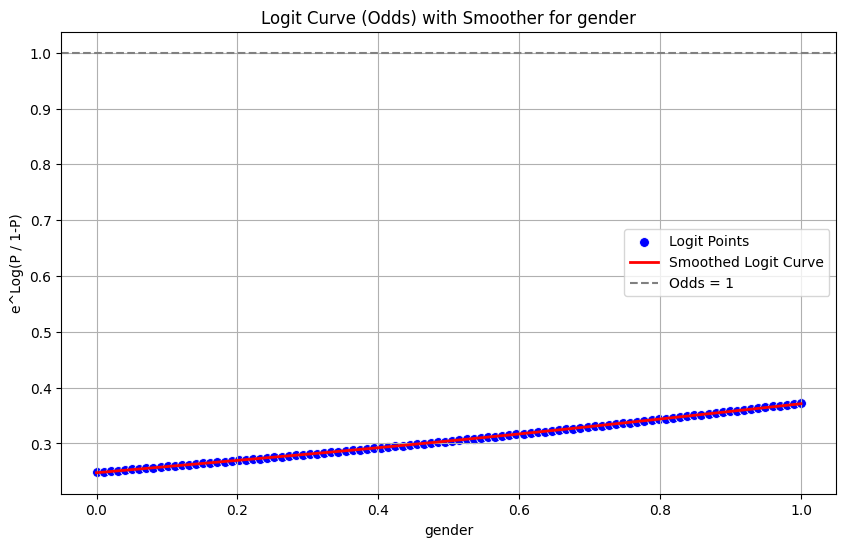

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def plot_logit_curve_with_smoother(result, predictor, feature_name):
    """
    Plot the logit curve (odds) for a given feature with scatter points and a smoother.

    Parameters:
    - result: Fitted logistic regression model.
    - predictor: Training dataset of predictors.
    - feature_name: The feature for which to plot the logit curve.
    """
    # Generate a range of values for the selected feature
    feature_values = np.linspace(predictor[feature_name].min(), predictor[feature_name].max(), 100)
    
    # Keep other predictors fixed at their mean
    fixed_predictors = predictor.mean(axis=0).copy()
    
    # Calculate the logit (odds) for each feature value
    log_odds = []
    for value in feature_values:
        temp_predictors = fixed_predictors.copy()
        temp_predictors[feature_name] = value
        
        # Add constant and ensure shape matches model coefficients
        predictors_with_const = sm.add_constant(temp_predictors.values.reshape(1, -1), has_constant='add')
        logit = np.dot(predictors_with_const, result.params)
        odds = np.exp(logit)  
        log_odds.append(odds[0])
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        feature_name: feature_values,
        'log_odds': log_odds
    })
    
    # Plot the logit curve with points and smoother
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature_name, y='log_odds', data=plot_df, color='blue', s=50, label='Logit Points')
    sns.regplot(x=feature_name, y='log_odds', data=plot_df, scatter=False, lowess=True, 
                color='red', line_kws={'lw': 2}, label='Smoothed Logit Curve')
    
    plt.title(f'Logit Curve (Odds) with Smoother for {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('e^Log(P / 1-P)')
    plt.axhline(1, color='grey', linestyle='--', label='Odds = 1')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_logit_curve_with_smoother(result, predictor, 'age')
plot_logit_curve_with_smoother(result, predictor, 'dist')
plot_logit_curve_with_smoother(result, predictor, 'income')
plot_logit_curve_with_smoother(result, predictor, 'marital_status')
plot_logit_curve_with_smoother(result, predictor, 'gender')

